In [82]:
import os
import requests
import pandas as pd
import numpy as np
import datetime as dt
import alpaca_trade_api as tradeapi
import hvplot.pandas
from MCForecastTools import MCSimulation

import panel as pn
pn.extension()

import matplotlib.pyplot as plt

%matplotlib inline

In [52]:
# Load .env environment variables
from dotenv import load_dotenv
load_dotenv()

True

In [53]:
def get_workday(date):
    date = pd.to_datetime(date)
    offset = max(1, (date.weekday() + 6) % 7 - 3)
    timedelta = dt.timedelta(offset)
    return pd.Timestamp((date - timedelta).date(),tz="America/New_York").isoformat()

In [54]:
# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

api = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version = "v2"
)

In [55]:
# Format current date as ISO format
end_date = get_workday("today")
two_yrs = dt.timedelta(days=(365*2))
start_date = get_workday((pd.to_datetime("today") - two_yrs).date())
# Set the tickers
tickers = ["AAPL", "MSFT", "AMZN", "FB", "GOOGL", "BRK.B", "JNJ", "V", "PG", "SPY"]
# Set timeframe to '1D' for Alpaca API
timeframe = "1D"
# Get current closing prices for SPY and AGG
# YOUR CODE HERE!
df_portfolio = api.get_barset(
    tickers,
    timeframe,
    start = start_date,
    end = end_date
).df

df_portfolio.head()

AAPL                                       AMZN  \
                             open    high     low   close    volume     open   
time                                                                           
2018-11-02 00:00:00-04:00  209.55  213.89  205.43  206.14  82917876  1678.59   
2018-11-05 00:00:00-05:00  204.30  204.39  198.17  201.59  51670747  1657.57   
2018-11-06 00:00:00-05:00  201.92  204.72  201.69  203.78  27934956  1618.35   
2018-11-07 00:00:00-05:00  205.89  210.01  204.13  209.91  26705827  1673.00   
2018-11-08 00:00:00-05:00  209.94  210.12  206.75  208.49  19216333  1752.89   

                                                                ...     SPY  \
                              high       low    close   volume  ...    open   
time                                                            ...           
2018-11-02 00:00:00-04:00  1697.44  1651.830  1665.58  6221611  ...  274.74   
2018-11-05 00:00:00-05:00  1658.09  1596.360  1627.45  5231856  ...  272.44   
2018-11-06 00:00:00-05:00  1665.00  1614.550  1642.86  4000487  ...  273.32   
2018-11-07 00:00:00-05:00  1759.23  1664.075  1757.36  7606948  ...  277.56   
2018-11-08 00:00:00-05:00  1784.00  1725.110  1754.95  3299391  ...  280.14   

                                                                    V  \
                             high       low   close    volume    open   
time                                                                    
2018-11-02 00:00:00-04:00  275.23  269.5900  271.80  93545041  141.11   
2018-11-05 00:00:00-05:00  274.01  271.3500  273.38  55157537  139.80   
2018-11-06 00:00:00-05:00  275.30  273.2500  275.12  49731823  139.80   
2018-11-07 00:00:00-05:00  281.10  275.1398  280.91  84960994  142.34   
2018-11-08 00:00:00-05:00  281.22  279.2200  280.44  49392193  144.60   

                                                               
                               high      low   close   volume  
time                                                           
2018-11-02 00:00:00-04:00  141.4546  137.850  139.70  7017962  
2018-11-05 00:00:00-05:00  140.2100  138.070  139.79  5472273  
2018-11-06 00:00:00-05:00  140.9100  139.720  140.78  4203592  
2018-11-07 00:00:00-05:00  144.9000  142.320  144.79  8532136  
2018-11-08 00:00:00-05:00  145.4600  143.652  145.24  4277204  

[5 rows x 50 columns]

In [56]:
def risk_chart ():
    df = pd.DataFrame()
    for symbol in tickers:
        df[symbol] = df_portfolio[symbol]["close"]
    df_pct = df.pct_change().dropna()
    df_pct.index = df_pct.index.date
    df_pct = df_pct.tail(120)
    limit = (min(df_pct.min())-0.01, max(df_pct.max())+0.01)
    box_chart = df_pct.hvplot.box(
        ylim = limit,
        figsize = (10,20),
        title = "6 Months Percent Return Range Risk",
        xlabel = "Stock Symbol",
        ylabel = "Percent Returns"
    )
    return box_chart

In [57]:
risk_chart()

:BoxWhisker   [Variable]   (value)

In [112]:
def moving_avg (symbol):
    # slicing data
    df_ticker_price = pd.DataFrame()
    df_ticker_price[symbol] = df_portfolio[symbol]["close"]
    df_ticker_price[symbol + "mv21"] = df_ticker_price[symbol].rolling(window=21).mean()
    df_ticker_price[symbol + "mv200"] = df_ticker_price[symbol].rolling(window=200).mean()
    df_ticker_price = df_ticker_price.dropna().tail(6*21)
    scatter = df_ticker_price[symbol].hvplot.scatter()
    line21 = df_ticker_price[symbol + "mv21"].hvplot()
    line200 = df_ticker_price[symbol + "mv200"].hvplot()
    return (scatter * line21 * line200)

def MC_2wks(symbol):
    # slice data
    df = pd.DataFrame()
    df = df_portfolio[symbol]
    df.columns = pd.MultiIndex.from_product([[symbol], df.columns])
    fig = plt.figure()
    
    # Run simulation
    mcsim  =  MCSimulation(
        portfolio_data = df,
        num_simulation = 500,
        num_trading_days = 10
    )
    mcsim.calc_cumulative_return()
    
    # Get simulation results
    line_plot = mcsim.plot_simulation()
    mc_tbl = mcsim.summarize_cumulative_return()
    lower_pct = mc_tbl["95% CI Lower"]
    upper_pct = mc_tbl["95% CI Upper"]
    
    # Calculate percentile results
    close = df[symbol]["close"][-1]
    lower_price = lower_pct * close
    upper_price = upper_pct * close
    
    # Summarize result
    txt = f"Monte Carlo Simulation Result \n"\
        f"Based on today's {symbol} price (${close:.2f}) \n" \
        f"There's 95% chance that in 2 weeks {symbol}'s price be between ${lower_price:.2f} and ${upper_price:.2f}"
    
    # Return column pane
    return pn.Column("# Two Week Trajectory", line_plot.figure, txt)

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

Column
    [0] Markdown(str)
    [1] Matplotlib(Figure)
    [2] Markdown(str)
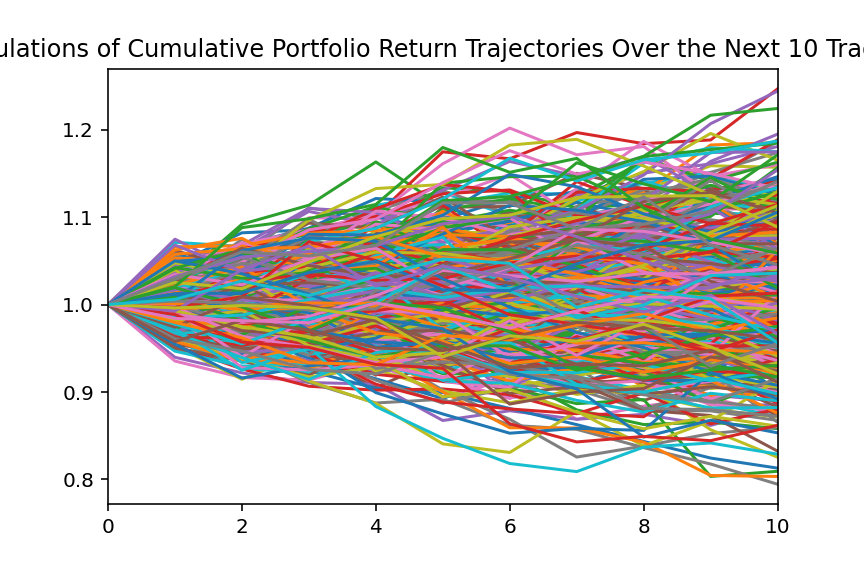

<Figure size 432x288 with 0 Axes>

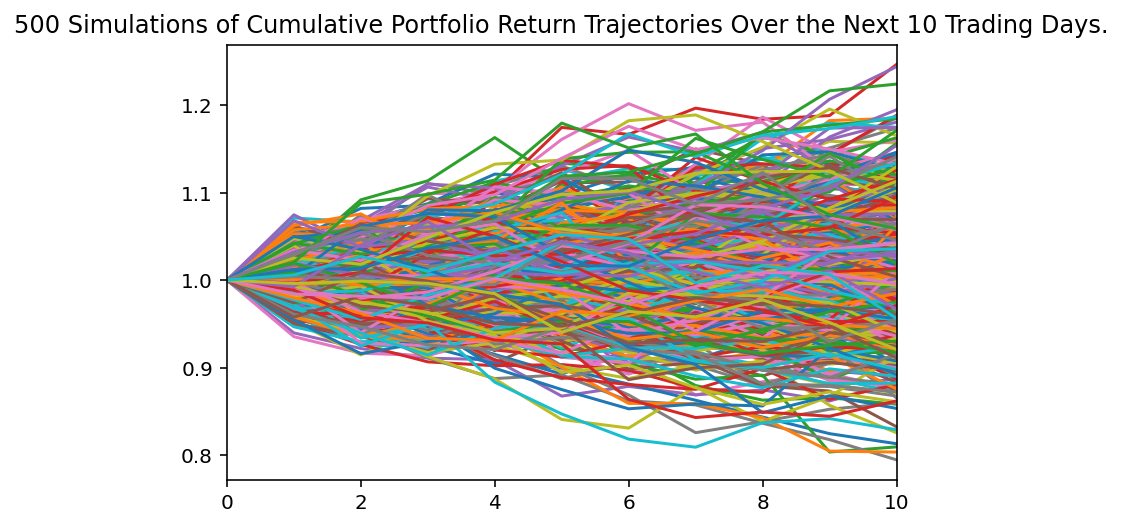

In [113]:
MC_2wks("FB")

Launching server at http://localhost:49654


Column
    [0] Markdown(str)
    [1] Matplotlib(Figure)
    [2] Markdown(str)
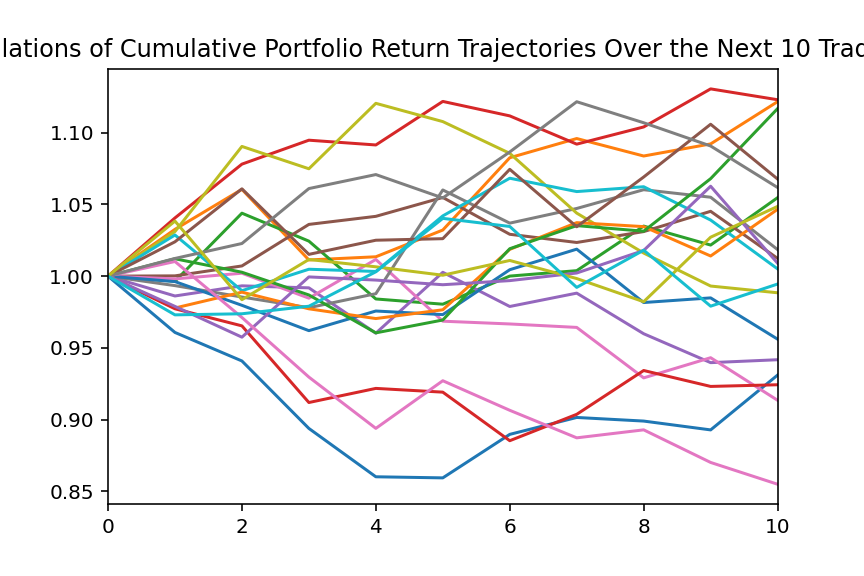